In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Dataset 확인

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-9/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-9/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/data/3-9/sample_submission.csv')

In [4]:
df_train.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


* 예측하려는 target label은 strength입니다.

In [5]:
df_train.shape

(5407, 10)

In [6]:
df_test.shape

(3605, 9)

* 8개의 컬럼을 이용하여(id, strength 제외) 5407개의 데이터를 훈련시켜 3605개의 데이터의 strength를 예측해야 한다.

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 422.5 KB


* 모든 변수가 수치형 변수이다.

In [7]:
df_train.describe()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,2703.000000,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,1561.010784,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,0.000000,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,1351.500000,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,2703.000000,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,4054.500000,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,5406.000000,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [9]:
df_train.isnull().sum()

id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

* null값은 없다.

## 1.1 Null data check

* null 값이 없으므로 pass

## 1.2 Target label 확인

In [11]:
print('강도 최대값 : {}'.format(df_train['Strength'].max()))
print('강도 최소값 : {}'.format(df_train['Strength'].min()))
print('평균 강도 : {}'.format(df_train['Strength'].mean()))

강도 최대값 : 82.6
강도 최소값 : 2.33
평균 강도 : 35.45207138894026


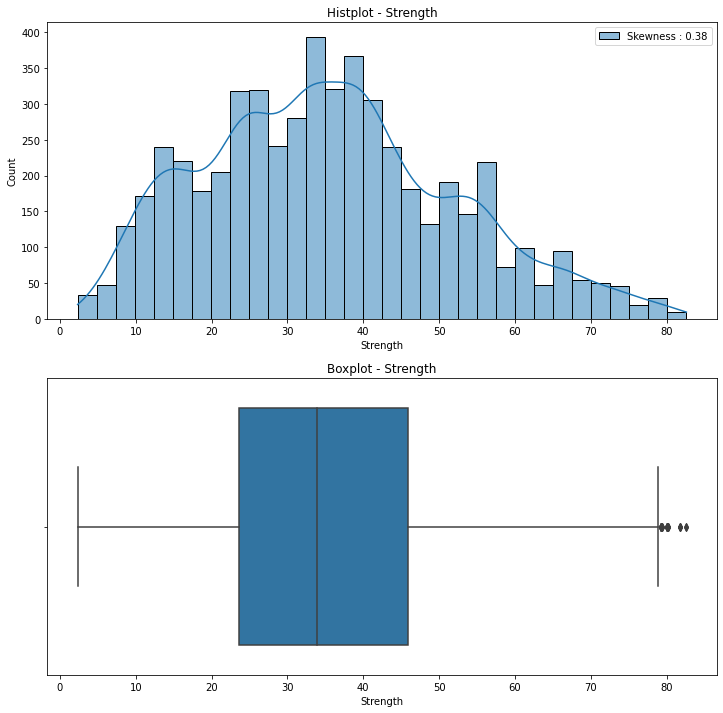

In [20]:
f, ax = plt.subplots(2, 1, figsize = (12, 12))

g = sns.histplot(df_train['Strength'], kde = True, label = 'Skewness : {:.2f}'.format(df_train['Strength'].skew()), ax = ax[0])
g = g.legend(loc = 'best')
ax[0].set_title('Histplot - Strength')

sns.boxplot(df_train['Strength'], ax = ax[1])
ax[1].set_title('Boxplot - Strength')

plt.show()

In [23]:
df_train[df_train['Strength'] >= 80]

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
269,269,238.1,0.0,0.0,185.7,0.0,1118.8,789.3,28,81.75
1193,1193,339.0,0.0,0.0,197.0,0.0,968.0,783.0,56,80.20
1760,1760,475.0,0.0,0.0,228.0,0.0,932.0,713.2,28,82.60
2039,2039,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,90,81.75
3623,3623,313.3,0.0,113.0,179.6,8.9,1001.9,688.7,28,82.60
4065,4065,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,270,81.75
4368,4368,202.0,11.0,126.0,206.0,1.7,801.0,801.0,28,80.20
4469,4469,427.5,47.5,0.0,228.0,0.0,932.0,594.0,90,81.75
5134,5134,252.5,0.0,0.0,185.7,0.0,1111.6,784.3,90,80.20
5323,5323,439.0,177.0,0.0,186.0,11.1,884.9,707.9,91,80.20


* 강도는 대부분 평균 주위에 분포해 있다.
* 왜도는 0.38로 균일하게 분포한다.
* 강도의 단위는 MPa(메가파스칼)이라는 단위를 쓰고 1MPa는 단위면적인 1㎠당 10kg의 하중을 견딜 수 있는 강도이다.
* boxplot 결과 80이상은 이상치로 보여진다.

# 2. Baseline model

In [25]:
X_train = df_train.drop(['id', 'Strength'], axis = 1)
y_train = df_train['Strength']

X_test = df_test.drop(['id'], axis = 1)

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

model = xgb.XGBRegressor()
model.fit(X_tr, y_tr)
score = mean_squared_error(y_vld, model.predict(X_vld))
score

160.1728551010044

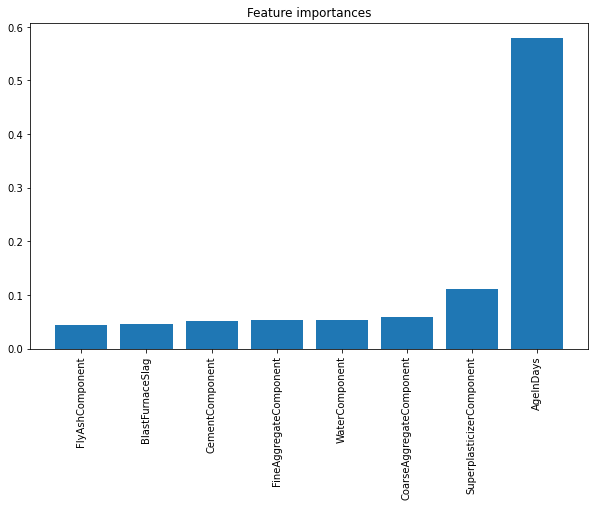

In [26]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [27]:
predictions = model.predict(X_test)
predictions

array([44.749374, 18.792154, 33.12571 , ..., 49.477467, 42.276142,
       22.628086], dtype=float32)

In [28]:
sub['Strength'] = predictions
sub.to_csv('/content/drive/MyDrive/data/3-9/sample_submission.csv', index = False)